In [1]:
##
## UNet 
##
## Взята идея по описанию из https://github.com/pietz/unet-keras
##
##
## 2017-07-28
##   Добавлены flip+rotation LB=760393
##
## 2017-07-29
##   LB=769123 += 3000
##
## 2017-07-31
##   Level-1, KFold = 5, xloss, only flip
##   Покoпытим этот вариант, пока других идей нет
##
##

In [2]:
import sys,os,datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import fbeta_score
import sklearn.metrics as skm
from __future__ import print_function

In [3]:
print(np.__version__);
print(pd.__version__);

1.13.1
0.19.2


In [4]:
import  cv2 as cv
cv.__version__

'3.2.0'

In [5]:
#from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential, save_model, load_model, Input, Model
from keras.layers import Convolution2D, MaxPooling2D, Convolution1D, MaxPooling1D, UpSampling2D, ZeroPadding2D
from keras.layers import Conv2D, Concatenate, Reshape
from keras.layers import Activation, Dropout, Flatten, Dense, Permute
from keras.layers.normalization import BatchNormalization
import keras.optimizers
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
import keras.backend as K

Using TensorFlow backend.


In [6]:
keras.__version__

'2.0.6'

In [7]:
#---------------------------------------------------------------------

In [8]:
!ls -la ..
#!ls -la ../Data
#!ls -la ../Data/training

total 25
drwxrwxrwx 1 boba boba 4096 июл 26 11:10 .
drwxrwxrwx 1 boba boba    0 июл 25 09:21 ..
drwxrwxrwx 1 boba boba 4096 июл 25 09:23 Data
drwxrwxrwx 1 boba boba    0 июл 25 09:22 Data-Arch
drwxrwxrwx 1 boba boba    0 июл 25 09:26 Data-Keras
drwxrwxrwx 1 boba boba 4096 июл 31 02:13 .git
-rwxrwxrwx 2 boba boba  130 июл  9 12:02 .gitignore
drwxrwxrwx 1 boba boba    0 июл 26 10:11 .ipynb_checkpoints
drwxrwxrwx 1 boba boba    0 июл 31 03:00 Jupyter
drwxrwxrwx 1 boba boba 4096 июл 31 18:57 Jupyter-Net
drwxrwxrwx 1 boba boba 4096 июл 30 17:32 Result
drwxrwxrwx 1 boba boba 4096 июл 30 17:41 Temp
drwxrwxrwx 1 boba boba    0 июл 27 07:53 Work


In [9]:
dirData = '../Data'
dirTemp = '../Temp'
dirWork = '../Work'

dirTest  = os.path.join(dirData,'testing','images')
dirTrain = os.path.join(dirData,'training','images')
dirMask  = os.path.join(dirData,'training','truth')

In [10]:
listTrain = os.listdir(dirTrain)
listMask  = os.listdir(dirMask)
listTest  = os.listdir(dirTest)
listTrain = [xx for xx in listTrain if os.path.splitext(xx)[1]=='.tif']
listMask  = [xx for xx in listMask  if os.path.splitext(xx)[1]=='.png']
listTest  = [xx for xx in listTest  if os.path.splitext(xx)[1]=='.tif']
print(len(listTrain),len(listMask),len(listTest))
print(listTrain[:5],'\n',listMask[:5],'\n',listTest[:5])

168 168 162
['i105404.tif', 'i117557.tif', 'i124017.tif', 'i130790.tif', 'i137857.tif'] 
 ['i105404_mask.png', 'i117557_mask.png', 'i124017_mask.png', 'i130790_mask.png', 'i137857_mask.png'] 
 ['i105047.tif', 'i116596.tif', 'i137649.tif', 'i140176.tif', 'i142099.tif']


In [11]:
if 0 :
    for xx in listTrain[:5] :
        img = cv.imread(os.path.join(dirTrain,xx),-1)
        xxm = os.path.splitext(xx)[0]+"_mask.png"
        msk = cv.imread(os.path.join(dirMask,xxm),-1)
        plt.subplot(121); plt.imshow(img); plt.subplot(122); plt.imshow(msk,'gray'); plt.show()
    plt.close()

In [12]:
#msk.shape, img.shape, img.min(), img.max(), msk.max(), #img[6:10,6:10], msk[6:10,6:10]

In [13]:
flagGray = False
Gauss    = 5
Median   = 5
if flagGray :
    trX, trY, trX0, trY0 = [], [], np.zeros((512,512,1)), np.zeros((512,512,1))
else :
    trX, trY, trX0, trY0 = [], [], np.zeros((512,512,3)), np.zeros((512,512,1))

for xx in listTrain :
    img = cv.imread(os.path.join(dirTrain,xx),-1)
    if 1 and (Gauss or Median): 
        for cc in range(img.shape[2]) : 
            if Gauss  : img[:,:,cc] = cv.GaussianBlur(img[:,:,cc],(Gauss,Gauss),0);
            if Median : img[:,:,cc] = cv.medianBlur  (img[:,:,cc],Median);
    xxm = os.path.splitext(xx)[0]+"_mask.png"
    msk = cv.imread(os.path.join(dirMask,xxm),-1)
    #print(img.mean(),msk.mean())
    if flagGray :
        img = cv.cvtColor(img,cv.COLOR_RGB2GRAY);
        trX0[6:506,6:506,0] = img[:,:]/255.0
        trY0[6:506,6:506,0] = msk[:,:]/255.0
    else :
        trX0[6:506,6:506,:] = img[:,:,:]/255.0
        trY0[6:506,6:506,0] = msk[:,:]/255.0
        trY0[trY0>=0.5] = 1.0
    trX.append(trX0.copy())
    trY.append(trY0.copy())
    #print(trX0.mean(),trY0.mean(),trX1[-1].mean(),trY1[-1].mean())

#print([trY[xx].mean() for xx in range(10)])
trX = np.array(trX)
trY = np.array(trY)

# аугментация
trXX, trYY, trXXX,trYYY = trX.copy(), trY.copy(), np.zeros((1)), np.zeros((1))


if 1 :
    # flipping
    for f in range(-1,2) :
        trXXX, trYYY = trX.copy(), trY.copy()
        for p in range(trXXX.shape[0]) :
            trXXX[p], trYYY[p,:,:,0] = cv.flip(trXXX[p],f), cv.flip(trYYY[p,:,:,0],f)
        trXX = np.vstack([trXX,trXXX])
        trYY = np.vstack([trYY,trYYY])
        print('flip :',f,trXX.shape,trYY.shape)

if 0 :
    # rotate +-90

    # rotate +90
    trXXX, trYYY = trX.copy(), trY.copy()
    for p in range(trX.shape[0]) :
        for i in range(trX.shape[1]) :
            for j in range(trX.shape[2]) :
                trXXX[p,i,j,:] = trX[p,j,trX.shape[1]-i-1]
                trYYY[p,i,j,:] = trY[p,j,trY.shape[1]-i-1]
    trXX = np.vstack([trXX,trXXX])
    trYY = np.vstack([trYY,trYYY])
    print('rotate +90:',trXX.shape,trYY.shape)

    # rotate -90
    trXXX, trYYY = trX.copy(), trY.copy()
    for p in range(trX.shape[0]) :
        for i in range(trX.shape[1]) :
            for j in range(trX.shape[2]) :
                trXXX[p,i,j,:] = trX[p,trX.shape[2]-j-1,i]
                trYYY[p,i,j,:] = trY[p,trY.shape[2]-j-1,i]
    trXX = np.vstack([trXX,trXXX])
    trYY = np.vstack([trYY,trYYY])
    print('rotate -90:',trXX.shape,trYY.shape)
    
trX, trY = trXX.copy(), trYY.copy()
del trXX,trYY
del trXXX,trYYY

# Считаем среднее по каналам и вычитаем из изображений
meanX = (trX[:,6:-6,6:-6,:].mean(axis=(1,2))).mean(axis=0)
stdX  = (trX[:,6:-6,6:-6,:].mean(axis=(1,2))).std(axis=0)
for cc in range(meanX.shape[0]) : 
    trX[:,6:-6,6:-6,cc] -= meanX[cc]    
print("mean={} std={}".format(meanX,stdX))
    
trX.shape, trX.min(), trX.max(), trY.shape, trY.min(), trY.max()
#[trY[xx].mean() for xx in range(10)]

flip : -1 (336, 512, 512, 3) (336, 512, 512, 1)
flip : 0 (504, 512, 512, 3) (504, 512, 512, 1)
flip : 1 (672, 512, 512, 3) (672, 512, 512, 1)
mean=[ 0.6473997   0.48950165  0.70839568] std=[ 0.06249822  0.09179847  0.08778627]


((672, 512, 512, 3),
 -0.62212117329585626,
 0.48696893986925865,
 (672, 512, 512, 1),
 0.0,
 1.0)

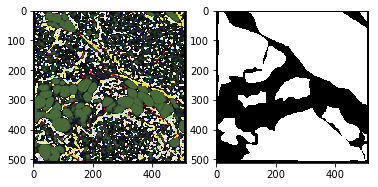

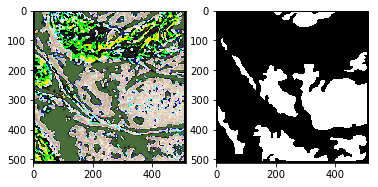

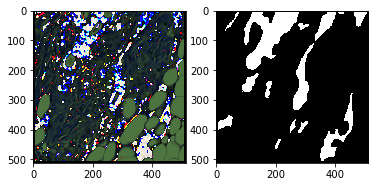

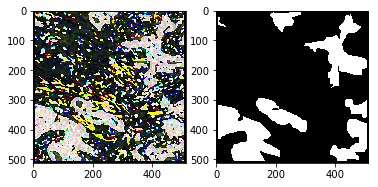

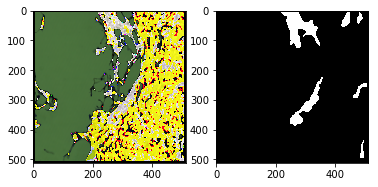

In [14]:
for xx in range(5) :
    img = trX[xx]
    xxm = trY[xx]
    plt.subplot(121); plt.imshow(img); plt.subplot(122); plt.imshow(xxm[:,:,0],'gray'); plt.show()
plt.close()

In [15]:
#
# model UNET
#
#    https://github.com/pietz/unet-keras
#
#

def level_block(m, dim, depth, acti, dropout=0.25, batch=True):
    if depth > 0:
        
        x = m
        if batch : x = BatchNormalization()(x)
        n = Conv2D(dim, (3, 3), activation=acti, padding='same')(x) #(m)
        n = Conv2D(dim, (3, 3), activation=acti, padding='same')(n)
        if dropout : n = Dropout(dropout)(n) ## add
        m = MaxPooling2D((2, 2))(n)
        m = level_block(m, 2*dim, depth-1, acti, dropout=dropout, batch=batch)
        m = UpSampling2D((2, 2))(m)
        m = Conv2D(dim, (2, 2), activation=acti, padding='same', kernel_initializer='he_normal')(m)
        if dropout : m = Dropout(dropout)(m) ## add
        m = Concatenate(axis=3)([n, m])
    m = Conv2D(dim, (3, 3), activation=acti, padding='same')(m)
    return Conv2D(dim, (3, 3), activation=acti, padding='same')(m)

def UNet(img_shape, n_out=2, dim=32, depth=5, acti='relu', flatten=False, dropout=0.25, batch=True):
    i = Input(shape=img_shape)
    ## ???? i = ZeroPadding2D((6,6),data_format="channels_last")
    o = level_block(i, dim, depth, acti, dropout=dropout, batch=batch)
    o = Conv2D(n_out, (1, 1), name='prediction')(o)
    if flatten:
        o = Reshape(n_out, img_shape[0] * img_shape[1])(o)
        o = Permute((2, 1))(o)
    #o = Activation('relu')(o)
    if batch : o = BatchNormalization()(o)  ######
    o = Activation('sigmoid')(o)
    return Model(inputs=i, outputs=o)


In [16]:
model10 = UNet((512,512,3),depth=4,n_out=1, dropout=0.05)
model10.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 512, 512, 3)   0                                            
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 512, 512, 3)   12          input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 512, 512, 32)  896         batch_normalization_1[0][0]      
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 512, 512, 32)  9248        conv2d_1[0][0]                   
___________________________________________________________________________________________

In [143]:
#
# 2017-07-31
#   Перестроил реализацию на метод ZFTurbo : +1.0 к знаменателю и числителю. Более корректно работает на пустых картинках.
#   На пустых картинках возможно зависание (==0, nan для x=0,  g = 0, s <> 0 (10-200))
#
#   Не очень понятно как это работает на всем batch, но на одном с batch_size=1 должно работать корректно
#
#
def dice (truth,pred) :
    g, s = K.sum(truth), K.sum(pred)
    x    = K.sum(truth*pred)
    return((2.0*x+1.0)/(g+s+1.0))
    #return((1.0 if K.sum(g+s)==0.0 else 2.0*x/(g+s+K.epsilon())))
    
def diceNP (truth,pred, printOK=False) :
    g, s = truth.sum(), pred.sum()
    x    = (truth*pred).sum()
    if printOK : print('x={} g={} s={}'.format(x,g,s))
    return((2.0*x+1.0)/(g+s+1.0))
    #return((1.0 if K.sum(g+s)==0.0 else 2.0*x/(g+s+K.epsilon())))

def f1 (truth,pred) :
    TP = K.sum(truth*pred)
    TN = K.sum((1.0-truth)*(1.0-pred))
    FP = K.sum(truth*(1.0-pred))
    FN = K.sum((1.0-truth)*pred)

    
    P  = 1.0 if K.sum(TP+FP)==0.0 else TP/(TP+FP)
    R  = 0.0 if K.sum(TP+FN)==0.0 else TP/(TP+FN) 

    F1 = 0.0 if K.sum(P+R)  ==0.0 else 2.0*P*R/(P+R)

    return(F1)

def f1dice (truth,pred) :
    return ((dice(truth,pred)+f1(truth,pred))/2.0)
    
def lossdice (truth,pred) :
    return(1.0 - dice(truth,pred))

def lossfd (truth,pred) :
    return(1.0 - f1dice(truth,pred))
    
import keras.losses as losses

def lossXdice (truth,pred) :
    return(losses.binary_crossentropy(truth,pred) - K.log(dice(truth,pred)+K.epsilon()))

In [77]:
def buildModel (input_shape) :
##    model = UNet(input_shape,depth=5,n_out=1,dropout=0.05,batch=False)
    model = UNet(input_shape,depth=5-1,n_out=1,dropout=0.05,batch=False)
    
    sgd = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
    #model.compile(loss='mean_absolute_error',  #'binary_crossentropy',
    model.compile(loss=lossXdice, #'mean_absolute_error',  #'binary_crossentropy',
                  optimizer=sgd, #sgd, #"adam", #'rmsprop',
                  metrics=[dice,'binary_accuracy']) #['binary_accuracy']) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])
    return(model)

In [19]:
K.clear_session()
model10 = buildModel((trX.shape[1],trX.shape[2],trX.shape[3]))
model10.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 512, 512, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 512, 512, 32)  896         input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 512, 512, 32)  9248        conv2d_1[0][0]                   
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 512, 512, 32)  0           conv2d_2[0][0]                   
___________________________________________________________________________________________

In [20]:
#model10.load_weights('../Data-Keras/Models/model-UNet-weights.h5', by_name=False)
batch_size = 1

In [127]:
epochs     = 150
#epochs     = 50
verbose    = 2
batch_size = 1
metric     = 'binary_accuracy'
metric     = 'dice'

############trX, trY = trX[0:30], trY[0:30]

##folds      = 10
folds      = 5
##folds      = 3
foldN      = trX.shape[0]/folds+1

print(datetime.datetime.now(),'Training with folds')

for i in range(3,folds) :
#for i in range(1,2) :

    print(datetime.datetime.now(),'------------>',i)

    K.clear_session()
    model10 = buildModel((trX.shape[1],trX.shape[2],trX.shape[3]))
    ############if 1 : model10.load_weights('../Temp/TempTempG5M5KFoldMean/V1-UNET-val_dice=0.7660-2.hdf5')

    early_stopping = EarlyStopping(monitor='val_loss', patience=12,min_delta=0.0001,verbose=1)
#    early_stopping = EarlyStopping(monitor='val_loss', patience=5,min_delta=0.0001,verbose=1)
    reduce_lr1     = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0000001,verbose=1)
    reduce_lr2     = ReduceLROnPlateau(monitor='loss',     factor=0.5, patience=3, min_lr=0.0000001,verbose=1)

    filepath="../Temp/NewStep/Level-1-loss/V1-UNET-val_"+metric+"={val_"+metric+":.4f}-{"+metric+":.4f}---"+str(i)+".hdf5"
    #filepath="../Temp/NewStep/StandartF5/V1-UNET-val_"+metric+"={val_"+metric+":.4f}-{"+metric+":.4f}---"+str(i)+".hdf5"
    #filepath="../Temp/TempTempG5M5KFold10/V1-UNET-val_"+metric+"={val_"+metric+":.4f}-{"+metric+":.4f}---"+str(i)+".hdf5"
    #checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    checkpoint1 = ModelCheckpoint(filepath, monitor=metric,        verbose=1, save_best_only=True, mode='max')
    checkpoint2 = ModelCheckpoint(filepath, monitor='val_'+metric, verbose=1, save_best_only=True, mode='max')

    step  = 60
    low   = 0
    high  = low+step
    
    tFold = [True]*(i*foldN)+[False]*foldN+[True]*trX.shape[0];
    tFold = tFold[:trX.shape[0]]
    
    vFold = [not xx for xx in tFold]

    #hist1  = model10.fit(trX[low:high],trY[low:high],
    hist1  = model10.fit(trX[tFold],trY[tFold],
                        epochs=epochs, batch_size=batch_size, 
                        #validation_split=0.20, 
                        validation_data=(trX[vFold],trY[vFold]),
                        initial_epoch = 0,
                        #callbacks=[early_stopping,reduce_lr1,reduce_lr2,checkpoint],
                        callbacks=[reduce_lr1,reduce_lr2,checkpoint1,checkpoint2,early_stopping],
                        verbose=verbose)

print(datetime.datetime.now())

2017-07-31 14:44:35.888035 Training with folds
2017-07-31 14:44:35.889450 ------------> 3
Train on 537 samples, validate on 135 samples
Epoch 1/150
Epoch 00000: dice improved from -inf to 0.52889, saving model to ../Temp/NewStep/Level-1-loss/V1-UNET-val_dice=0.5754-0.5289---3.hdf5
Epoch 00000: val_dice improved from -inf to 0.57545, saving model to ../Temp/NewStep/Level-1-loss/V1-UNET-val_dice=0.5754-0.5289---3.hdf5
215s - loss: 1.4473 - dice: 0.5289 - binary_accuracy: 0.7777 - val_loss: 1.3716 - val_dice: 0.5754 - val_binary_accuracy: 0.8040
Epoch 2/150
Epoch 00001: dice improved from 0.52889 to 0.56825, saving model to ../Temp/NewStep/Level-1-loss/V1-UNET-val_dice=0.5588-0.5682---3.hdf5
Epoch 00001: val_dice did not improve
211s - loss: 1.3101 - dice: 0.5682 - binary_accuracy: 0.8178 - val_loss: 1.4849 - val_dice: 0.5588 - val_binary_accuracy: 0.7698
Epoch 3/150
Epoch 00002: dice improved from 0.56825 to 0.58185, saving model to ../Temp/NewStep/Level-1-loss/V1-UNET-val_dice=0.5777-0.

KeyboardInterrupt: 

In [21]:
#!ls ../Temp/TempTempG5M5KFold -la | tail
#!ls ../Temp/TempTempG5M5KFold10 -la | tail
#!ls ../Temp/NewStep/StandartF3 -la | tail
!ls ../Temp/NewStep/Level-1-loss -la | tail

-rwxrwxrwx 1 boba boba 62214256 июл 31 11:18 V1-UNET-val_dice=0.8157-0.8493---1.hdf5
-rwxrwxrwx 1 boba boba 62214256 июл 31 11:36 V1-UNET-val_dice=0.8160-0.8652---1.hdf5
-rwxrwxrwx 1 boba boba 62214256 июл 31 11:29 V1-UNET-val_dice=0.8165-0.8592---1.hdf5
-rwxrwxrwx 1 boba boba 62214256 июл 31 11:43 V1-UNET-val_dice=0.8166-0.8710---1.hdf5
-rwxrwxrwx 1 boba boba 62214256 июл 31 12:01 V1-UNET-val_dice=0.8167-0.8773---1.hdf5
-rwxrwxrwx 1 boba boba 62214256 июл 31 11:50 V1-UNET-val_dice=0.8172-0.8742---1.hdf5
-rwxrwxrwx 1 boba boba 62214256 июл 31 11:57 V1-UNET-val_dice=0.8176-0.8759---1.hdf5
-rwxrwxrwx 1 boba boba 62214256 июл 31 12:08 V1-UNET-val_dice=0.8176-0.8778---1.hdf5
-rwxrwxrwx 1 boba boba 62214256 июл 31 11:53 V1-UNET-val_dice=0.8177-0.8753---1.hdf5
-rwxrwxrwx 1 boba boba 62214256 июл 31 11:39 V1-UNET-val_dice=0.8183-0.8691---1.hdf5


In [22]:
if 0 : model10 = load_model('../Temp/TrainModel001+G+M/V1-UNET-0.8511.hdf5')
if 0 : model10 = load_model('../Temp/V1-UNET-0.8853.hdf5')
#if 1 : model10 = load_model('../Temp/TempTempM3/V1-UNET-0.9054.hdf5')
if 0 : model10.load_weights('../Temp/TempTempM3/V1-UNET-0.9054.hdf5')
if 0 : model10.load_weights('../Temp/TempTempG5M5/V1-UNET-val_dice=0.7307.hdf5')
if 0 : model10.load_weights('../Temp/TempTempG5M5KFold/V1-UNET-val_dice=0.7879-2.hdf5')
if 0 : model10.load_weights('../Temp/TempTempG5M5KFoldMean/V1-UNET-val_dice=0.7632-2.hdf5')
if 0 : model10.load_weights('../Temp/TempTempG5M5KFoldMean/V1-UNET-val_dice=0.7660-2.hdf5')
if 0 : model10.load_weights('../Temp/TempTempG5M5KFoldMean/V1-UNET-val_dice=0.7828-2.hdf5')
if 0 : model10.load_weights('../Temp/TempTempG5M5KFold5/V1-UNET-val_dice=0.8224-0.8516---1.hdf5') # 769128
if 0 : model10.load_weights('../Temp/TempTempG5M5KFold5/V1-UNET-val_dice=0.8217-0.8655---1.hdf5') # 765XXX
if 0 : model10.load_weights('../Temp/TempTempG5M5KFold5/V1-UNET-val_dice=0.8227-0.8643---3.hdf5')    
if 0 : model10.load_weights('../Temp/TempTempG5M5KFold10/V1-UNET-val_dice=0.8315-0.8617---9.hdf5')    
if 0 : model10.load_weights('../Temp/NewStep/StandartF3/V1-UNET-val_dice=0.7655-0.7360---2.hdf5')    
if 0 : model10.load_weights('../Temp/NewStep/Level-1/V1-UNET-val_dice=0.7561-0.7261---2.hdf5')    
if 0 : model10.load_weights('../Temp/NewStep/Level-1-loss/V1-UNET-val_dice=0.8063-0.8532---0.hdf5') # 767XXX
if 1 : model10.load_weights('../Temp/NewStep/Level-1-loss/V1-UNET-val_dice=0.8183-0.8691---1.hdf5') # 770XXX

In [23]:
%time trP = model10.predict(trX,batch_size=batch_size)

CPU times: user 47.4 s, sys: 11.9 s, total: 59.3 s
Wall time: 59.5 s


In [132]:
def thP01 (trP, th=0.5) :
    trP01 = trP.copy()
    trP01[trP>th] =1.0
    trP01[trP<=th]=0.0
    trP01 = trP01.astype(np.uint8)
    return(trP01)

def thP01OTSU (trP, ext=False) :
    trP01 = trP.copy()
    th_otsu = []
    for i in range(trP.shape[0]) :
        trP01X = (trP[i,:,:,0]*255.0).astype(np.uint8)
        ret,trP01X = cv.threshold(trP01X,0,1,cv.THRESH_BINARY+cv.THRESH_OTSU)
        trP01[i,:,:,0] = trP01X[:,:]
        th_otsu.append(ret); #print(thresh,ret)
        #plt.subplot(121); plt.imshow(trP[i,:,:,0]); plt.subplot(122); plt.imshow(trP[i,:,:,0]); plt.show()
        
    if not ext : return(trP01)    
    
    th_otsu = np.array(th_otsu).astype(np.int16)/255.0
    return(trP01,th_otsu)
    #plt.hist(th_otsu.ravel(),bins=50); plt.show()
    #plt.close()        
    #print('th-otsu mean={}, std={}'.format(th_otsu.mean(),th_otsu.std()))
    #print(np.array(th_otsu[:166]))    
    

In [133]:
trP01 = thP01(trP)

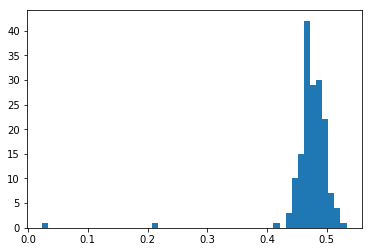

train th-otsu mean=0.472265532719, std=0.0445515139087


In [134]:
#
#
# 2017-07-31 otsu расчет для каждой картинки
#
#
otsu = 1
if otsu :
    trP01O, th_otsu = thP01OTSU(trP[:166],ext=True)
    plt.hist(th_otsu.ravel(),bins=50); plt.show()
    plt.close()        
    print('train th-otsu mean={}, std={}'.format(th_otsu.mean(),th_otsu.std()))
    #print(np.array(th_otsu[:166]))

In [135]:
if 0 : # Ощутимых результатов не дает, увеличение в +10-100
    times, medianP = 3,5
    for i in range(trP01.shape[0]) :
        for j in range(times) :
            trP01[i,:,:,0] = cv.medianBlur(trP01[i],medianP)

(512, 512, 3) (512, 512, 1) (672, 512, 512, 1) 4.25606e-19 1.0


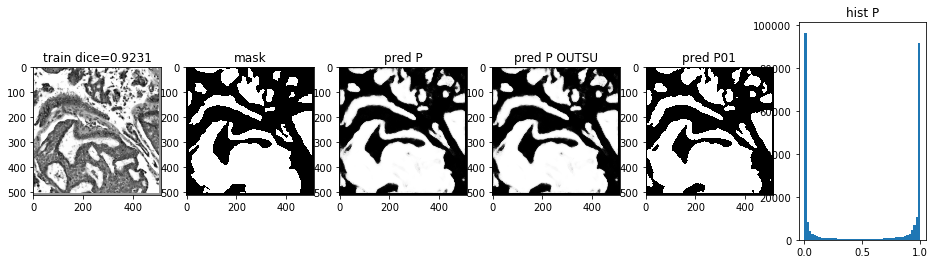

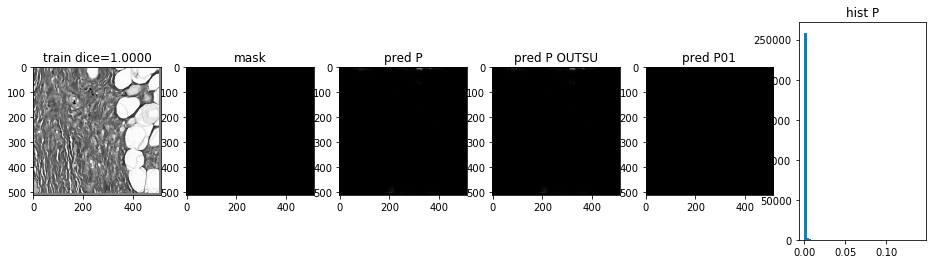

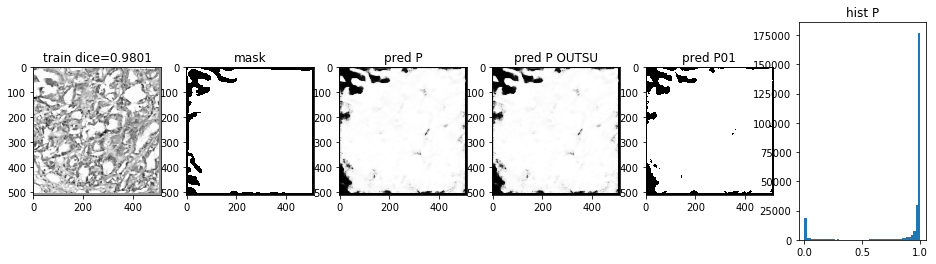

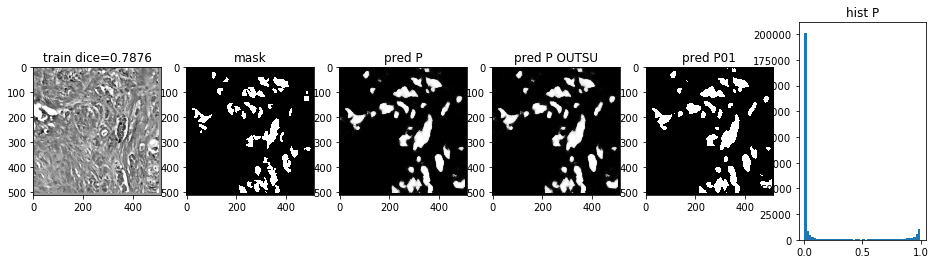

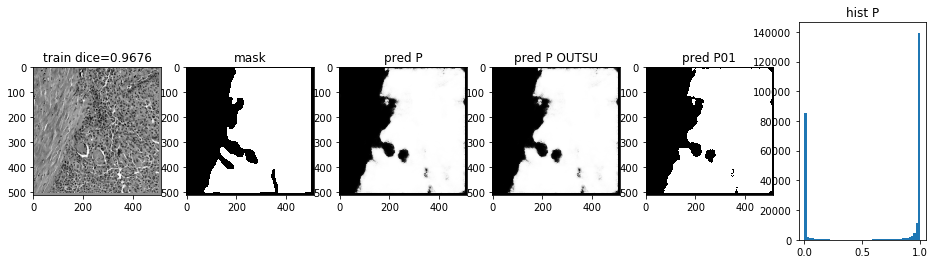

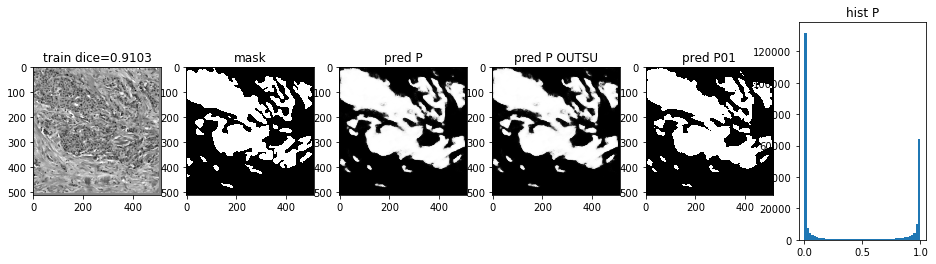

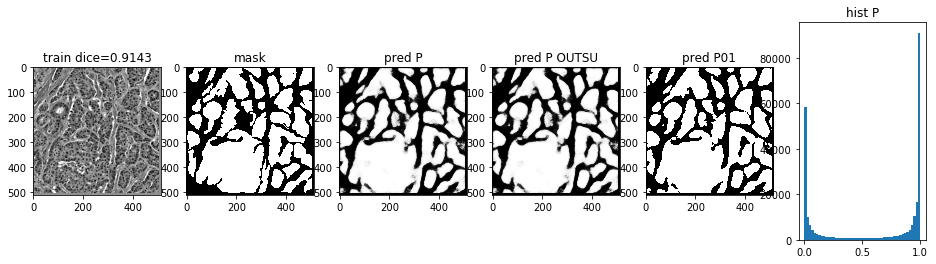

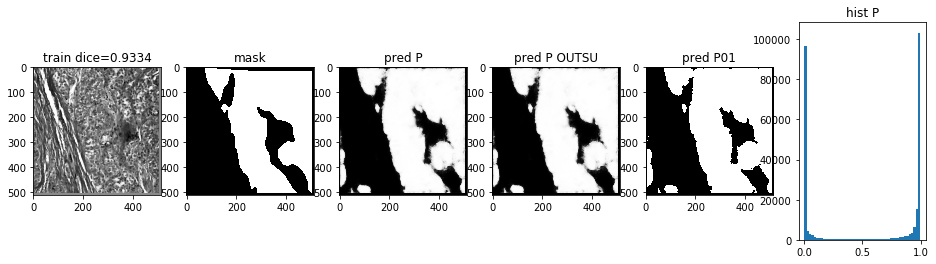

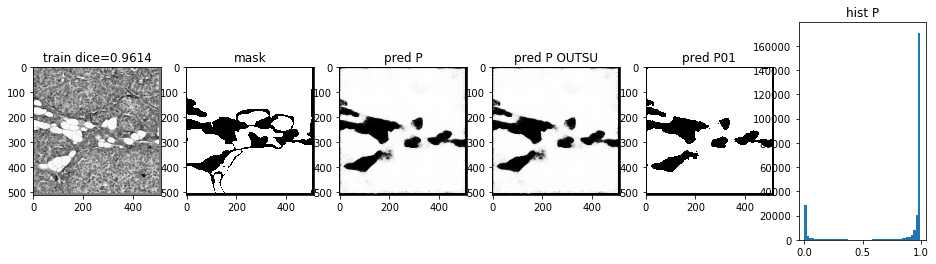

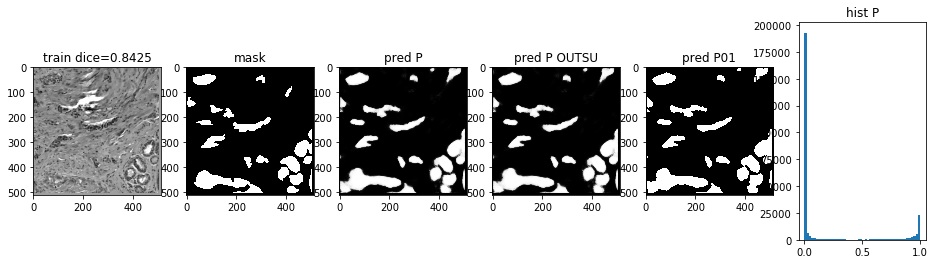

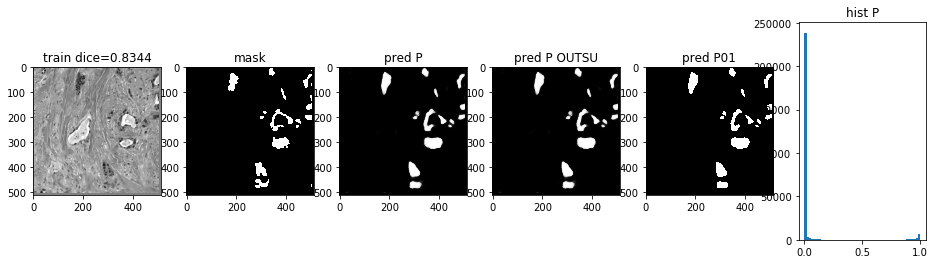

In [144]:
iii = 110
print(trX[0].shape,trY[0].shape,trP.shape,trP.min(),trP.max())
for ii in range(iii,iii+11) :
    plt.figure(figsize=(16,4))
    pdice = diceNP(trY[ii,:,:,0],trP01[ii,:,:,0])
    plt.subplot(161); plt.imshow(trX[ii,:,:,0],'gray'); plt.title('train dice={:.4f}'.format(pdice))
    plt.subplot(162); plt.imshow(trY[ii,:,:,0],'gray'); plt.title('mask')
    plt.subplot(163); plt.imshow(trP[ii,:,:,0],'gray'); plt.title('pred P')
    if otsu : plt.subplot(164); plt.imshow(trP[ii,:,:,0],'gray'); plt.title('pred P OUTSU')
    plt.subplot(165); plt.imshow(trP01[ii,:,:,0],'gray'); plt.title('pred P01')
    plt.subplot(166); plt.hist(trP[ii,:,:,0].ravel(),bins=50); plt.title('hist P')
    plt.show()
plt.close()

In [105]:
# Calculate F1-micro

In [106]:
TP = (trY[:,6:506,6:506,0]*trP01[:,6:506,6:506,0]).sum()
TN = ((1.0-trY[:,6:506,6:506,0])*(1.0-trP01[:,6:506,6:506,0])).sum()
FP = ((trY[:,6:506,6:506,0])*(1.0-trP01[:,6:506,6:506,0])).sum()
FN = ((1.0-trY[:,6:506,6:506,0])*(trP01[:,6:506,6:506,0])).sum()

P  = TP/(TP+FP) if (TP+FP)>0.0 else 1.0
R  = TP/(TP+FN) if (TP+FN)>0.0 else 0.0

F1 = 2.0*P*R/(P+R) if (P+R)>0.0 else 0.0

TP,TN,FP,FN,P,R,F1
#P*R,P+R, 2.0*P*R/(P+R)

(53210323.0,
 106356893.0,
 3142557.0,
 5290227.0,
 0.94423431420009052,
 0.9095696194309284,
 0.92657786537154352)

In [145]:
# Calculate DI- dice.mean()

In [146]:
diceTrain = []
for i in range(166) : #trP.shape[0]) :
    diceTrain.append(diceNP(trY[i,6:-6,6:-6,0],trP01[i,6:-6,6:-6,0]))
di = (np.array(diceTrain)).mean()
di #,np.array(dice)  #,np.array(XX)

0.88512390659934082

In [147]:
if 1 :
    di_th = []
    for i in range(1,10) : 
        th = (0.0+i)/10.0
        trP01D = thP01(trP,th=th)
        diceTrainD = []
        for i in range(166) : #trP.shape[0]) :
            diceTrainD.append(diceNP(trY[i,6:-6,6:-6,0],trP01D[i,6:-6,6:-6,0]))
        diD = (np.array(diceTrainD)).mean()
        di_th.append((th,diD))
di_th

[(0.1, 0.86434115576029358),
 (0.2, 0.87935256988451482),
 (0.3, 0.88273615968624286),
 (0.4, 0.88439068488151207),
 (0.5, 0.88512390659934082),
 (0.6, 0.88509072573348602),
 (0.7, 0.88380341080344571),
 (0.8, 0.88394084972111964),
 (0.9, 0.86294070068693973)]

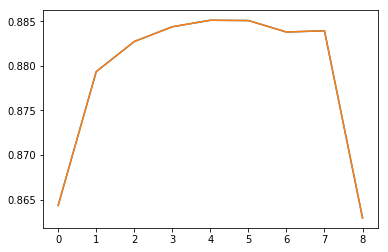

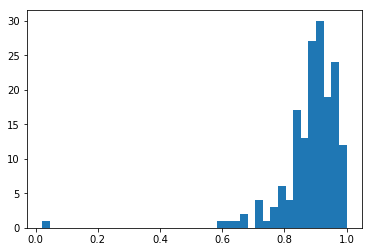

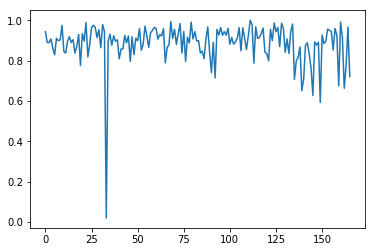

In [148]:
plt.plot(np.array([xx for th,xx in di_th])); plt.plot(np.array([xx for th,xx in di_th])); plt.show(); plt.close() 

plt.hist(np.array(diceTrain),bins=40); plt.show()
plt.plot(np.array(diceTrain)); plt.show()

In [149]:
1000000*(F1+di)/2.0

905850.8859854422

In [111]:
#np.array(dice)<0.4

In [112]:
# Подготовка test решения

In [113]:
if flagGray :
    trO, trO0 = [], np.zeros((512,512,1))
else :
    trO, trO0 = [], np.zeros((512,512,3))

for xx in listTest :
    img = cv.imread(os.path.join(dirTest,xx),-1)
    if 1 and (Gauss or Median): 
        for cc in range(img.shape[2]) : 
            if Gauss  : img[:,:,cc] = cv.GaussianBlur(img[:,:,cc],(Gauss,Gauss),0);
            if Median : img[:,:,cc] = cv.medianBlur  (img[:,:,cc],Median);
    #print(img.mean(),msk.mean())
    if flagGray :
        img = cv.cvtColor(img,cv.COLOR_RGB2GRAY);
        trO0[6:506,6:506,0] = img[:,:]/255.0
    else :
        trO0[6:506,6:506,:] = img[:,:,:]/255.0
    trO.append(trO0.copy())
    #print(trX0.mean(),trY0.mean(),trX1[-1].mean(),trY1[-1].mean())

#print([trY[xx].mean() for xx in range(10)])
trO = np.array(trO)

if 1 :
    for cc in range(meanX.shape[0]) : 
        trO[:,6:506,6:506,cc] -= meanX[cc]
    
trO.shape, trO.min(), trO.max()
#[trY[xx].mean() for xx in range(10)]

((162, 512, 512, 3), -0.6417290164331112, 0.47912580261435672)

In [114]:
%time trOP = model10.predict(trO,batch_size=batch_size)

CPU times: user 11.5 s, sys: 2.32 s, total: 13.8 s
Wall time: 13.3 s


In [119]:
trOP01 = thP01(trOP)

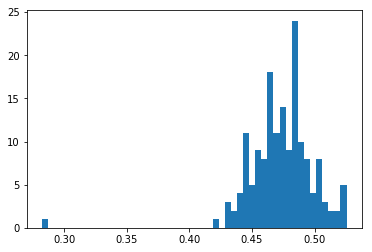

test th-otsu mean=0.473589929799, std=0.0262905944035


In [120]:
if otsu :
    trOP01O, th_otsu = thP01OTSU(trOP,ext=True)
    plt.hist(th_otsu.ravel(),bins=50); plt.show()
    plt.close()        
    print('test th-otsu mean={}, std={}'.format(th_otsu.mean(),th_otsu.std()))
    #print(np.array(th_otsu[:166]))

(512, 512, 3) (512, 512, 1) (162, 512, 512, 1) 2.00562e-18 1.0


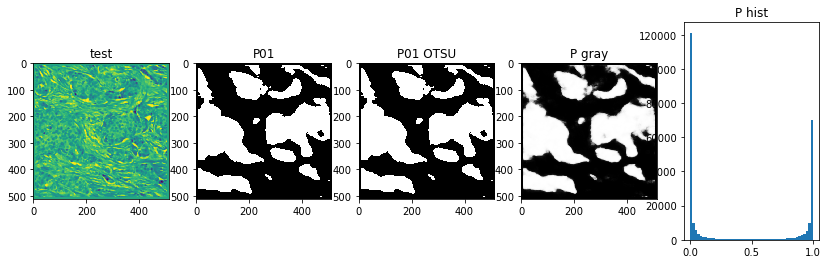

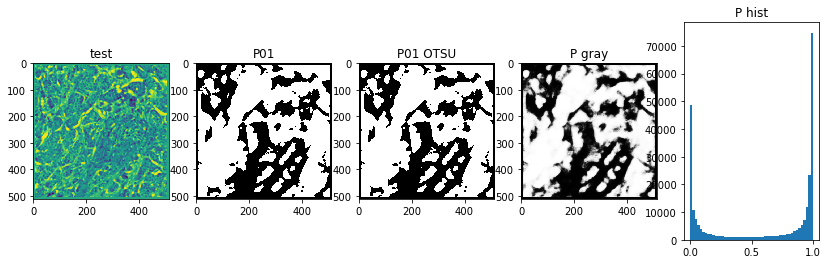

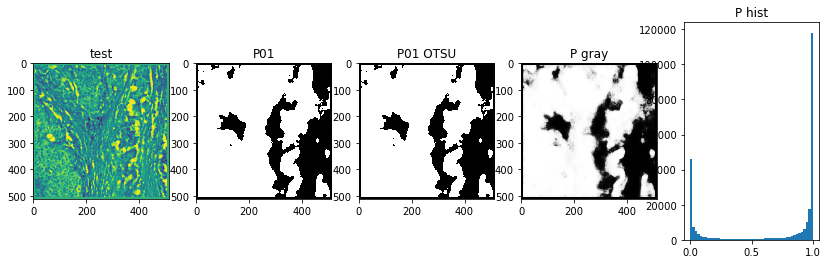

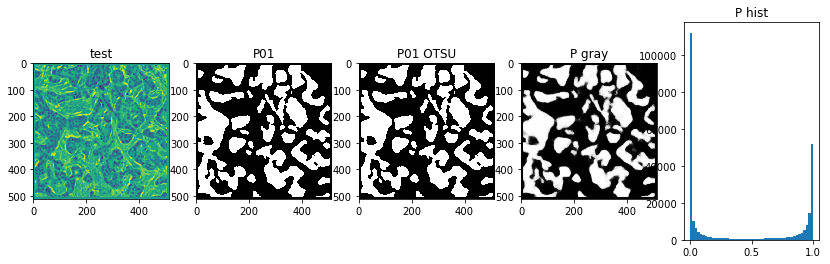

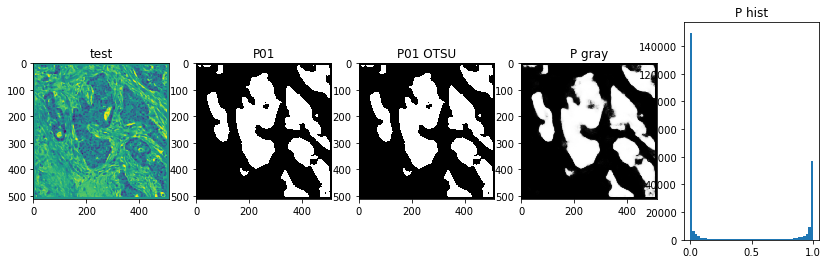

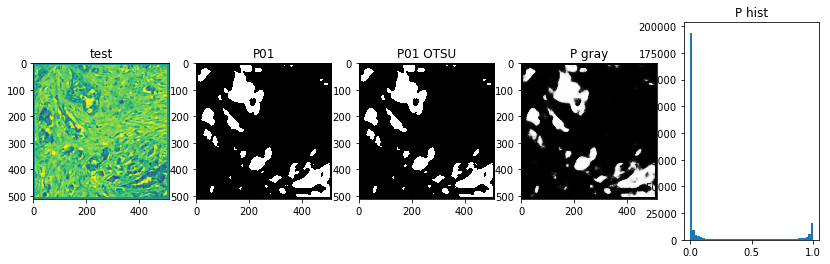

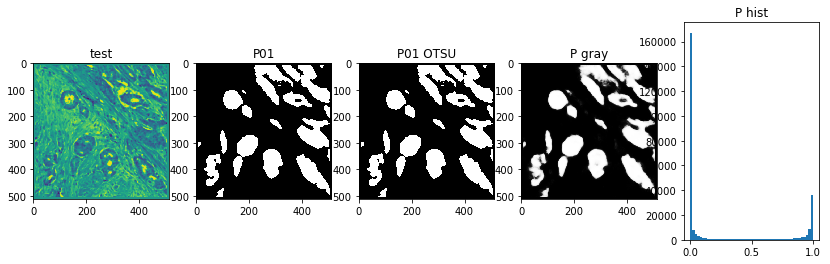

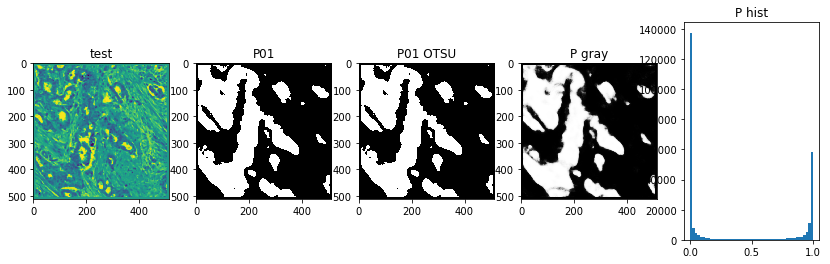

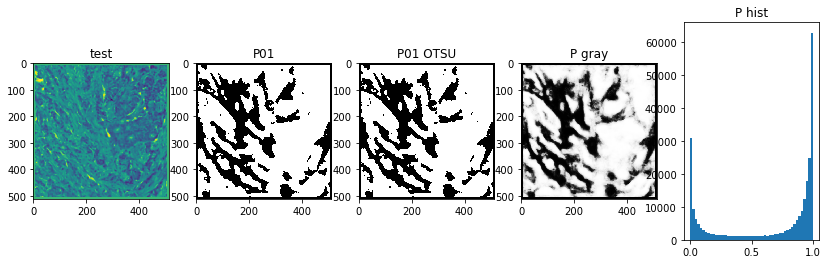

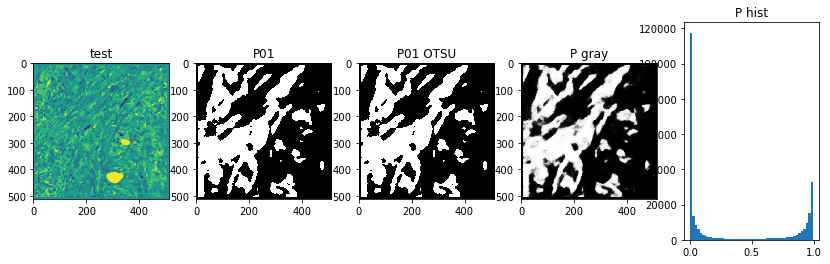

In [124]:
iii = 40
print(trO[0].shape,trP01[0].shape,trOP01.shape,trOP.min(),trOP.max())
for ii in range(iii,iii+10) :
    plt.figure(figsize=(17,4))
    plt.subplot(161); plt.imshow(trO[ii,:,:,0]); plt.title('test')
    plt.subplot(162); plt.imshow(trOP01 [ii,:,:,0],'gray'); plt.title('P01')
    if otsu : plt.subplot(163); plt.imshow(trOP01O[ii,:,:,0],'gray'); plt.title('P01 OTSU')
    plt.subplot(164); plt.imshow(trOP[ii,:,:,0],'gray');  plt.title('P gray')
    plt.subplot(165); plt.hist(trOP[ii,:,:,0].ravel(),bins=50);  plt.title('P hist')
    plt.show()
plt.close()

In [ ]:
if otsu : trOP01 = trOP01O

In [77]:
# Формирование выходной директории

In [78]:
def convert_to_binary(truth_png_file, truth_txt_file):
    im = Image.open(truth_png_file) #Can be many different formats.
    pix = im.load()
    with open(truth_txt_file, 'w') as out:
        for x in xrange(500):
            for y in xrange(500):
                out.write(str(int(pix[x, y] > 0)))
            out.write('\n')

if not os.path.exists('../Temp/random_submission'):
    os.makedirs('../Temp/random_submission')

# Training
for i in range(len(listTrain)) :
    fn = listTrain[i]
    truth_txt_file = '../Temp/random_submission/' + fn.split('.')[0] + '_mask.txt'
    with open(truth_txt_file, 'w') as out:
        for x in xrange(500):
            for y in xrange(500):
                out.write(str(int(trP01[i,y+6, x+6] > 0.0)))
            out.write('\n')
    out.close()
    
# Testing
for i in range(len(listTest)) :
    fn = listTest[i]
    truth_txt_file = '../Temp/random_submission/' + fn.split('.')[0] + '_mask.txt'
    with open(truth_txt_file, 'w') as out:
        for x in xrange(500):
            for y in xrange(500):
                out.write(str(int(trOP01[i,y+6, x+6] > 0.0)))
            out.write('\n')
    out.close()

In [79]:
import shutil

In [80]:
xx=shutil.make_archive('../Result/topcoderkonica','zip','../Temp/random_submission')
xx

'/media/boba/DATA/boba/Working/TopCoder/2017-07-25-Konica-Minolta/Result/topcoderkonica.zip'

In [400]:
!ls ../Temp -la

total 4610508
drwxrwxrwx 1 boba boba      4096 июл 26 10:58 .
drwxrwxrwx 1 boba boba      4096 июл 26 10:11 ..
drwxrwxrwx 1 boba boba         0 июл 25 18:17 .ipynb_checkpoints
drwxrwxrwx 1 boba boba     61440 июл 26 09:14 random_submission
-rwxrwxrwx 1 boba boba   1057596 июл 26 10:58 random_submission.zip
drwxrwxrwx 1 boba boba         0 июл 25 23:35 TrainModel001-G-M
drwxrwxrwx 1 boba boba         0 июл 25 22:21 TrainModel001-G+M
drwxrwxrwx 1 boba boba         0 июл 25 21:48 TrainModel001+G-M
drwxrwxrwx 1 boba boba      4096 июл 25 21:05 TrainModel001+G+M
-rwxrwxrwx 1 boba boba 248418336 июл 25 19:02 V1-UNET-0.8167.hdf5
-rwxrwxrwx 1 boba boba 248418336 июл 25 19:08 V1-UNET-0.8275.hdf5
-rwxrwxrwx 1 boba boba 248418336 июл 25 18:33 V1-UNET-0.8305.hdf5
-rwxrwxrwx 1 boba boba 248418336 июл 25 18:02 V1-UNET-0.8418.hdf5
-rwxrwxrwx 1 boba boba 248418336 июл 25 19:09 V1-UNET-0.8486.hdf5
-rwxrwxrwx 1 boba boba 248418336 июл 25 19:09 V1-UNET-0.8593.hdf5
-rwxrwxrwx 1 boba boba 248418336 июл 25 

In [389]:
!ls ../Work -la
#!ls ../Temp/random_submission

total 80768
drwxrwxrwx 1 boba boba        0 июл 26 09:17 .
drwxrwxrwx 1 boba boba     4096 июл 25 15:24 ..
-rwxrwxrwx 1 boba boba 82700662 июл 26 09:32 topcoderkonica.zip


In [36]:
if False :
    save_model(model10,'../Data-Keras/Models/model-UNet.h5')
    model10.save_weights('../Data-Keras/Models/model-UNet-weights.h5')

In [41]:
rrr=pd.DataFrame(res,columns=['image_name','tags']); rrr.head(); 
suffixDT = (datetime.datetime.now()).strftime('%Y-%m-%d-%H-%M-%S'); print(suffixDT)
rrr.to_csv('../Result/vss'+suffixDT+'.csv',index=False);

2017-05-20-05-51-18
